# Benchmarking InceptionTime on Smartwatch Gestures Dataset
FordA dataset from the UCR/UEA archive.
The following notebook tests the speed at which a given device can perform training iterations on the [FordA dataset](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/) (2 classes, 4,821 training sequences, 1 channel) training the InceptionTime architecture.

The test is designed to compare the M1 Max 24 Core 32 GB RAM GPU with the Colab Pro P100 GPU.

| Model | Dataset | Train Size | Sequence Length |
| ----- | ----- | ----- | ----- |
| [InceptionTime](https://github.com/hfawaz/InceptionTime) (trained from scratch) | Smartwatch Gestures (from TensorFlow Datasets) | ~4,800  images | 500 |

## Resources
* Code on GitHub: https://github.com/JanMarcelKezmann/colab_pro_vs_m1_max

# Imports

In [19]:
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff 

# Global Variables

In [2]:
N_CLASSES = 2
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
LR_PATIENCE = 15
NB_FILTERS = 32
USE_RESIDUAL = True
USE_BOTTLENECK = True
BOTTLENECK_SIZE = 32
DEPTH = 10
KERNEL_SIZE = 40
MONITOR = "val_loss"

# Download the FordA dataset & Perform Preprocessing

### Load the Data

In [44]:
train_path="FordA_TRAIN.arff"
test_path="FordA_TEST.arff"

def read_ariff(path):
    raw_data, meta = loadarff(path)
    cols = [x for x in meta]
    data2d = np.zeros([raw_data.shape[0], len(cols)])
    
    for i, col in zip(range(len(cols)),cols):
        data2d[:, i] = raw_data[col]

    return data2d

train_data = read_ariff(train_path)
test_data = read_ariff(test_path)
print(train_data.shape, test_data.shape)

(3601, 501) (1320, 501)


In [48]:
X_train = np.array([i[:-1] for i in train_data])
X_test = np.array([i[:-1] for i in test_data])

y_train = np.array([i[-1] == 1 for i in train_data], dtype=int)
y_test = np.array([i[-1] == 1 for i in test_data], dtype=int)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3601, 500) (3601,)
(1320, 500) (1320,)


### Visualize the Data

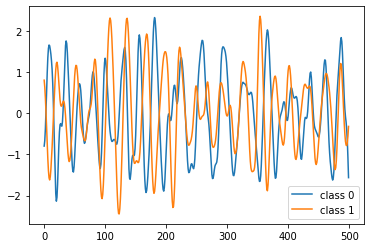

In [50]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_X_train = X_train[y_train == c]
    plt.plot(c_X_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()


### Standardize the Data

In [51]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [52]:
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [53]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# Build the Model

In [54]:
class InceptionTimeClassifier:
    def __init__(self, input_shape, nb_classes, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, bottleneck_size=32, depth=6,
                 kernel_size=40, nb_epochs=1500, callbacks=None):

        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size
        self.callbacks = callbacks
        self.batch_size = batch_size
        self.bottleneck_size = bottleneck_size
        self.nb_epochs = nb_epochs
        
        self.loss = 'sparse_categorical_crossentropy' # default: 'categorical_crossentropy'

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = tf.keras.layers.Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = tf.keras.layers.Conv1D(filters=self.nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = tf.keras.layers.Concatenate(axis=2)(conv_list)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(activation='relu')(x)
        
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = tf.keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = tf.keras.layers.BatchNormalization()(shortcut_y)

        x = tf.keras.layers.Add()([shortcut_y, out_tensor])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = tf.keras.layers.Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = tf.keras.layers.GlobalAveragePooling1D()(x)
        output_layer = tf.keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

        model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss=self.loss, optimizer=tf.keras.optimizers.Adam(), metrics=['sparse_categorical_accuracy']) # ['accuracy', MulticlassAUC()])

        return model

    def fit(self, x_train, y_train, class_weight=None, validation_data=None):
        hist = self.model.fit(
            x_train,
            y_train,
            batch_size=self.batch_size,
            epochs=self.nb_epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            class_weight=class_weight,
            validation_data=validation_data
        )

        tf.keras.backend.clear_session()

        return hist

    def predict(self, X_test):
        return self.model.predict(X_test, batch_size=self.batch_size, verbose=1)

In [55]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor=MONITOR,
        factor=0.5,
        patience=LR_PATIENCE,
        min_lr=LEARNING_RATE
    )
]
    
# Initialize and Compile Model
model = InceptionTimeClassifier(
    input_shape=X_train.shape[1:],
    nb_classes=N_CLASSES,
    verbose=True,
    build=True,
    batch_size=BATCH_SIZE,
    nb_filters=NB_FILTERS,
    use_residual=USE_RESIDUAL,
    use_bottleneck=USE_BOTTLENECK,
    bottleneck_size=BOTTLENECK_SIZE,
    depth=DEPTH,
    kernel_size=KERNEL_SIZE,
    nb_epochs=EPOCHS,
    callbacks=callbacks
)

2022-02-17 17:15:03.297877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-17 17:15:03.298341: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 500, 1)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 500, 32)      1280        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 500, 32)      640         ['input_1[0][0]']                
                                                            

# Train the Model

In [56]:
start_time = time()

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
)
print(f"Model training took {time() - start_time} seconds.")

2022-02-17 17:15:06.852311: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-02-17 17:15:08.038237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - ETA: 0s - loss: 0.2509 - sparse_categorical_accuracy: 0.8934

2022-02-17 17:15:17.263757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 12s 73ms/step - loss: 0.2509 - sparse_categorical_accuracy: 0.8934 - val_loss: 2.6046 - val_sparse_categorical_accuracy: 0.5106 - lr: 0.0010
Epoch 2/20
113/113 [==============================] - 7s 62ms/step - loss: 0.1787 - sparse_categorical_accuracy: 0.9300 - val_loss: 0.1925 - val_sparse_categorical_accuracy: 0.9197 - lr: 0.0010
Epoch 3/20
113/113 [==============================] - 7s 62ms/step - loss: 0.1579 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.1771 - val_sparse_categorical_accuracy: 0.9265 - lr: 0.0010
Epoch 4/20
113/113 [==============================] - 7s 64ms/step - loss: 0.1516 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.5712 - val_sparse_categorical_accuracy: 0.7985 - lr: 0.0010
Epoch 5/20
113/113 [==============================] - 7s 63ms/step - loss: 0.1367 - sparse_categorical_accuracy: 0.9436 - val_loss: 0.1834 - val_sparse_categorical_accuracy: 0.9402 - lr: 0.0010
Epoch 6/20
113/113 [====================

# Computing Inference Time on all examples

In [57]:
%%timeit
y = model.predict(X_test)

2022-02-17 17:17:33.847363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 1s 13ms/step
573 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
